# Semantic Segmantion with Hugging Face's Transformers & Amazon SageMaker


Transformer models are changing are changing the world of machine learning, starting with natural language processing, and now, with audio and computer vision. Hugging Face's mission is to democratize good machine learning and giving any one the opportunity to use these new state-of-the-art machine learning models. 
Together with Amazon SageMaker and AWS we have been working on extending the functionalities of the Hugging Face Inference DLC and the Python SageMaker SDK to make it easier to use speech and vision models together with `transformers`. 
You can now use the Hugging Face Inference DLC to do [automatic speech recognition](https://huggingface.co/tasks/automatic-speech-recognition) using MetaAIs [wav2vec2](https://arxiv.org/abs/2006.11477) model or Microsofts [WavLM](https://arxiv.org/abs/2110.13900) or use NVIDIAs [SegFormer](https://arxiv.org/abs/2105.15203) for [image segmentation](https://huggingface.co/tasks/image-segmentation).


This guide will walk you through how to do [Image Segmentation](https://huggingface.co/tasks/image-segmentation) using [segformer](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512) and new `DataSerializer` 
![overview](imgs/semantic_segmentation.png)


In this example you will learn how to: 

1. Setup a development Environment and permissions for deploying Amazon SageMaker Inference Endpoints.
2. Deploy a segformer model to Amazon SageMaker for image segmentation
3. Send requests to the endpoint to do image segmentation.
   
Let's get started! 🚀

---

*If you are going to use Sagemaker in a local environment (not SageMaker Studio or Notebook Instances). You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.*


## 1. Setup a development Environment and permissions for deploying Amazon SageMaker Inference Endpoints.

Setting up the development environment and permissions needs to be done for the automatic-speech-recognition example and the semantic-segmentation example. First we update the `sagemaker` SDK to make sure we have new `DataSerializer`. 


In [ ]:
%pip install sagemaker segmentation-mask-overlay pillow matplotlib --upgrade

After we have update the SDK we can set the permissions.

_If you are going to use Sagemaker in a local environment (not SageMaker Studio or Notebook Instances). You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [2]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


## 2. Deploy a segformer model to Amazon SageMaker for image segmentation


Image Segmentation divides an image into segments where each pixel in the image is mapped to an object. This task has multiple variants such as instance segmentation, panoptic segmentation and semantic segmentation.

We use the [nvidia/segformer-b0-finetuned-ade-512-512](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512) model running our segmentation endpoint. This model is fine-tuned on ADE20k (scene-centric image) at resolution 512x512.


In [4]:
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.serializers import DataSerializer

# Hub Model configuration. <https://huggingface.co/models>
hub = {
    'HF_MODEL_ID':'nvidia/segformer-b0-finetuned-ade-512-512',
    'HF_TASK':'image-segmentation',
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   env=hub,                      # configuration for loading model from Hub
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.26",  # transformers version used
   pytorch_version="1.13",        # pytorch version used
   py_version='py39',            # python version used
)


Before we are able to deploy our `HuggingFaceModel` class we need to create a new serializer, which supports our audio data. The Serializer are used in Predictor and in the `predict` method to serializer our data to a specific `mime-type`, which send to the endpoint. The default serialzier for the HuggingFacePredcitor is a JSNON serializer, but since we are not going to send text data to the endpoint we will use the DataSerializer.

In [5]:
# create a serializer for the data
image_serializer = DataSerializer(content_type='image/x-image') # using x-image to support multiple image formats

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
	initial_instance_count=1, # number of instances
	instance_type='ml.g4dn.xlarge', # ec2 instance type
  serializer=image_serializer, # serializer for our audio data.
)

-----------!

## 3. Send requests to the endpoint to do image segmentation.

The `.deploy()` returns an `HuggingFacePredictor` object with our `DataSeriliazer` which can be used to request inference. This `HuggingFacePredictor` makes it easy to send requests to your endpoint and get the results back.

We will use 2 different methods to send requests to the endpoint:

a. Provide a image file via path to the predictor  
b. Provide binary image data object to the predictor

### a. Provide a image file via path to the predictor

Using a image file as input is easy as easy as providing the path to its location. The `DataSerializer` will then read it and send the bytes to the endpoint. 

We can use a `libirispeech` sample hosted on huggingface.co

In [6]:
!wget https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/raw/main/ADE_val_00000001.jpg

--2023-03-21 08:29:41--  https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/raw/main/ADE_val_00000001.jpg
Resolving huggingface.co (huggingface.co)... 52.203.75.138, 3.216.111.67, 3.83.196.160, ...
Connecting to huggingface.co (huggingface.co)|52.203.75.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52650 (51K) [image/jpeg]
Saving to: ‘ADE_val_00000001.jpg’

100%[======================================>] 52,650      --.-K/s   in 0.001s  

2023-03-21 08:29:41 (43.8 MB/s) - ‘ADE_val_00000001.jpg’ saved [52650/52650]



before we send our request lest create a helper function to display our segmentation results.

In [7]:
from PIL import Image
import io
from segmentation_mask_overlay import overlay_masks
import numpy as np
import base64
import matplotlib.pyplot as plt


def stringToRGB(base64_string):
    # convert base64 string to numpy array
    imgdata = base64.b64decode(str(base64_string))
    image = Image.open(io.BytesIO(imgdata))
    return np.array(image)

def get_overlay(original_image_path,result):
    masks = [stringToRGB(r["mask"]).astype('bool') for r in res]
    masks_labels = [r["label"] for r in result]
    cmap = plt.cm.tab20(np.arange(len(masks_labels)))

    image = Image.open(original_image_path)
    overlay_masks(image, masks, labels=masks_labels, colors=cmap, mask_alpha=0.5)

To send a request with provide our path to the audio file we can use the following code:

dict_keys(['score', 'label', 'mask'])


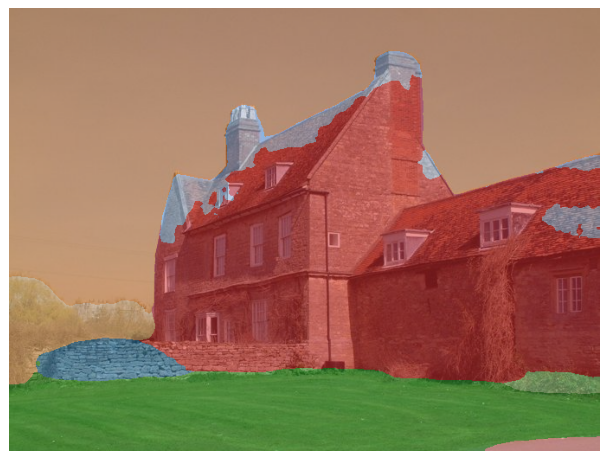

In [8]:
image_path = "ADE_val_00000001.jpg"

res = predictor.predict(data=image_path)
print(res[0].keys())
get_overlay(image_path,res)

### b. Provide binary image data object to the predictor

Instead of providing a path to the image file we can also directy provide the bytes of it reading the file in python.

_make sure `ADE_val_00000001.jpg` is in the directory_

dict_keys(['score', 'label', 'mask'])


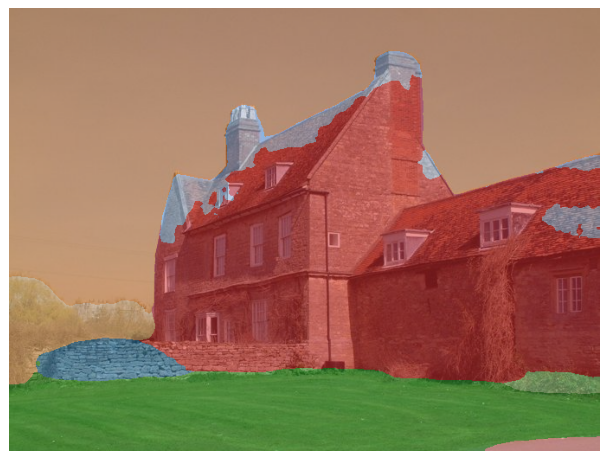

In [9]:
image_path = "ADE_val_00000001.jpg"

with open(image_path, "rb") as data_file:
  image_data = data_file.read()
  res = predictor.predict(data=image_data)
  print(res[0].keys())
  get_overlay(image_path,res)

### Clean up

In [10]:
predictor.delete_model()
predictor.delete_endpoint()